# Delft 3D Verify 

This code will compare experimental data to the simulated data on Delft3D.


This experimental data was collected during a flume test as documented in this citation. THE nondimentaionalized data is loi
>   P. Mycek, B. Gaurier, G. Germain, G. Pinon, and E. Rivoalen, “Experimental study of the turbulence intensity effects on marine current turbines behaviour. Part I: One single turbine,” Renew. Energy, vol. 66, pp. 729–746, 2014, doi: 10.1016/j.renene.2013.12.036.  
```
u*flow rate (ex:0.8 m/s)= raw velocity 
y=0 at center of flume 
Downstream*diameter of turbine(ex:0.7)= meters downstream 
Velocity 15% inlet TI
   u*	y*	Downstream
0.51	0	1.2
0.595	0	2
0.788	0	3
0.862	0	4
0.911	0	5
0.913	0	6
0.927	0	7
0.953	0	8
0.965	0	9
0.954	0	10
```

In [1]:
from os.path import abspath, dirname, join, normpath, relpath
from mhkit.river.io import d3d 
from math import isclose
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import netCDF4
import math
plt.rcParams.update({'font.size': 15}) # Set fount size of plots title and labels 

## Experimental data

In [2]:
#Experimental data
# ucx_experiment= np.array([0.51, 0.595, 0.788, 0.862, 0.911, 0.913, 0.927, 0.953, 0.965, 0.954])*0.8
#x = np.array([1.2, 2, 3, 4, 5, 6, 7, 8, 9, 10])*turbine_diameter+turbine_x

#Import Experimental data 
ucx_experiment= pd.read_csv("Mycek_03TI_vel.txt", delimiter="\t")
ucx_experiment['u']=ucx_experiment['u*']*0.8
ucx_experiment_centerline= ucx_experiment[ucx_experiment['y*'].values==0]
ucx_experiment_centerline


,u*,y*,Downstream,u
13,0.503,0.0,1.2,0.4024
40,0.504,0.0,2.0,0.4032
67,0.495,0.0,3.0,0.3960
94,0.482,0.0,4.0,0.3856
121,0.503,0.0,5.0,0.4024
148,0.556,0.0,6.0,0.4448
175,0.617,0.0,7.0,0.4936
202,0.685,0.0,8.0,0.5480
229,0.711,0.0,9.0,0.5688
256,0.763,0.0,10.0,0.6104


##  Simulated Data

In [3]:
# Downloading Data
datadir = normpath(join(relpath(join('data', 'river', 'd3d'))))
filename= 'Flume_verify_8m_map.nc' 
d3d_data = netCDF4.Dataset(join(datadir,filename)) 

In [4]:
# Getting variable data 
variable= 'ucx' 
var_data_df= d3d.get_all_data_points(d3d_data, variable, time_index=-1)
print(var_data_df)


          x    y         z       ucx   time
0       0.1  1.1  0.202957  0.574387  300.0
1       0.3  1.1  0.199863  0.553914  300.0
2       0.1  1.3  0.202957  0.574387  300.0
3       0.5  1.1  0.199627  0.559213  300.0
4       0.3  1.3  0.199863  0.553914  300.0
...     ...  ...       ...       ...    ...
15745  17.7  4.7  1.800354  0.990992  300.0
15746  17.5  4.9  1.800341  0.974414  300.0
15747  17.9  4.7  1.799983  1.003881  300.0
15748  17.7  4.9  1.800354  0.990857  300.0
15749  17.9  4.9  1.799984  1.003718  300.0

[15750 rows x 5 columns]


### Creating Points to interpolate onto 

In [5]:
xmin=var_data_df.x.max()
xmax=var_data_df.x.min()

ymin=var_data_df.y.max()
ymax=var_data_df.y.min()

zmin=var_data_df.z.max()
zmax=var_data_df.z.min()
print(np.unique(var_data_df.z))

# Creating one array and 2 points 
turbine_diameter= 0.7 #meters
turbine_x=6
x = np.array(ucx_experiment_centerline.Downstream*turbine_diameter+turbine_x)
y = np.mean([ymin,ymax])
z = np.mean([zmin,zmax])

# Creating an array of points  
cline_points = d3d.create_points(x, y, z)
cline_points

[0.19689641 0.19689641 0.19732871 ... 1.80038104 1.80041619 1.80045244]
0


,x,y,z
0,6.84,3.0,0.998674
1,7.40,3.0,0.998674
2,8.10,3.0,0.998674
3,8.80,3.0,0.998674
4,9.50,3.0,0.998674
5,10.20,3.0,0.998674
6,10.90,3.0,0.998674
7,11.60,3.0,0.998674
8,12.30,3.0,0.998674
9,13.00,3.0,0.998674


### Plotting Results

[0.5786394  0.58094159 0.59341234 0.62088592 0.64566385 0.66356491
 0.67760463 0.68901983 0.69870554 0.70703779]


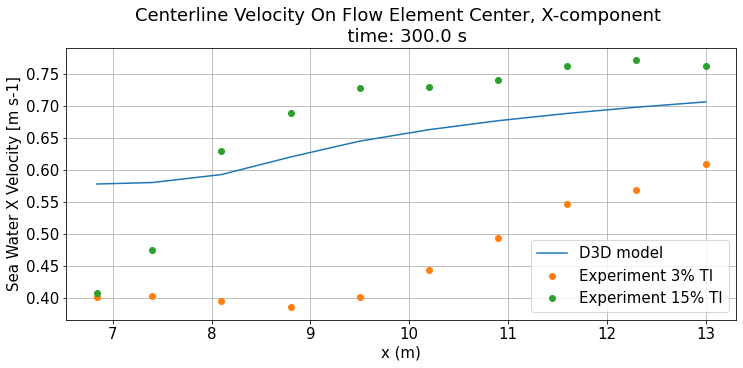

In [10]:
cline_variable = interp.griddata(var_data_df[['x','y','z']], 
                     var_data_df[variable],
                     cline_points[['x','y','z']]) 
print(cline_variable)
# Plotting
Type='Centerline'
plt.figure(figsize=(12,5))
Model= plt.plot(x, cline_variable, label="D3D model")
Exp=plt.plot(x, ucx_experiment_centerline.u,'o', label="Experiment 3% TI")

ucx_experiment= np.array([0.51, 0.595, 0.788, 0.862, 0.911, 0.913, 0.927, 0.953, 0.965, 0.954])*0.8
x = np.array([1.2, 2, 3, 4, 5, 6, 7, 8, 9, 10])*turbine_diameter+turbine_x
Exp=plt.plot(x, ucx_experiment,'o', label="Experiment 15% TI")
plt.grid()
plt.xlabel('x (m)')

y_name= f'{d3d_data.variables[variable].standard_name}'
y_label=' '.join([x.capitalize() for x in y_name.split('_')])
plt.ylabel(f'{y_label} [{d3d_data.variables[variable].units}]')

title_name= f'{d3d_data.variables[variable].long_name}'
title_label=' '.join([x.capitalize() for x in title_name.split(' ')])
plt.title(f'{Type} {title_label} \n  time: {var_data_df.time[1]} s')
plt.legend()

### standard devation

In [7]:
 # Square deviations
deviations = (cline_variable - ucx_experiment_centerline.u)
print(deviations)
# Variance
MAPE= sum(deviations/ ucx_experiment_centerline.u)*100/10
print(MAPE)
MSE=sum((deviations/ucx_experiment_centerline.u)**2)/10
print(MSE)
max_error= 100*max(deviations/ ucx_experiment_centerline.u)
print(max_error)

13     0.176239
40     0.177742
67     0.197412
94     0.235286
121    0.243264
148    0.218765
175    0.184005
202    0.141020
229    0.129906
256    0.096638
Name: u, dtype: float64
41.0067576959396
0.18967521530632225
61.018132956255045


[0, 1, 2]


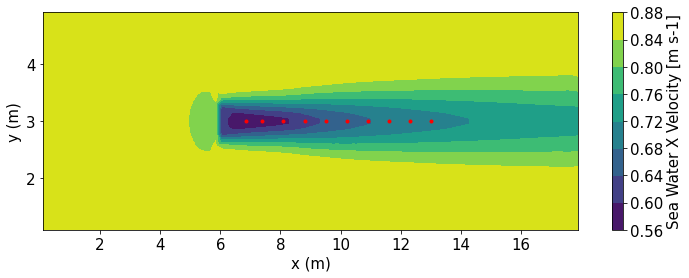

In [8]:
x_contour = np.linspace(xmin, xmax, num=100)
y_contour = np.linspace(ymin, ymax, num=40)
z_contour = np.mean([zmin,zmax])

contour_points = d3d.create_points(x_contour, y_contour, z_contour) 


contour_variable = interp.griddata(var_data_df[['x','y','z']], 
                                                     var_data_df[variable],
                                                     contour_points[['x','y','z']])


# Plotting 
Type= 'Contour'
plt.figure(figsize=(12,4))
contour_plot = plt.tricontourf(contour_points.x,contour_points.y,contour_variable)
                               #vmin=min_plot_v,vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.plot(cline_points['x'], cline_points['y'], '.', color= 'red')

plt.xlabel('x (m)')
plt.ylabel('y (m)')
title_name= f'{d3d_data.variables[variable].long_name}'
title_label=' '.join([x.capitalize() for x in title_name.split(' ')])
#plt.title(f'{Type} {title_label} \n  Layer: {layer}')

cbar= plt.colorbar(contour_plot)
cbar_name= f'{d3d_data.variables[variable].standard_name}'
cbar_label=' '.join([x.capitalize() for x in cbar_name.split('_')])
cbar.set_label(f'{cbar_label} [{d3d_data.variables[variable].units}]')

0


InvalidIndexError: (slice(None, None, None), None)

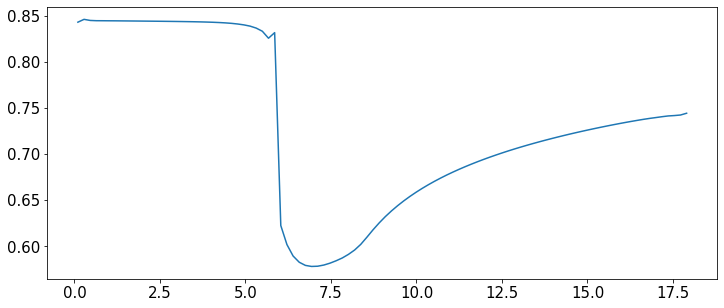

In [9]:
x_line = np.linspace(xmin, xmax, num=100)
y = np.mean([ymin, ymax])
z = np.mean([zmin,zmax])

contour_points = d3d.create_points(x_line, y, z) 

cline_variable = interp.griddata(var_data_df[['x','y','z']], 
                     var_data_df[variable],
                     contour_points[['x','y','z']]) 
# Plotting
Type='Centerline'
plt.figure(figsize=(12,5))
Model= plt.plot(x_line, cline_variable, label="D3D model")
Exp=plt.plot(x, ucx_experiment,'o', label="Experiment")
plt.grid()
plt.xlabel('x (m)')

y_name= f'{d3d_data.variables[variable].standard_name}'
y_label=' '.join([x.capitalize() for x in y_name.split('_')])
plt.ylabel(f'{y_label} [{d3d_data.variables[variable].units}]')

title_name= f'{d3d_data.variables[variable].long_name}'
title_label=' '.join([x.capitalize() for x in title_name.split(' ')])
plt.title(f'{Type} {title_label} \n  time: {var_data_df.time[1]} s')
plt.legend()

In [ ]:
TI= d3d.turbulent_intensity(d3d_data, points= contour_points ,intermediate_values = True) 

In [ ]:
# Creating new plot limits 
max_plot_v= 0.3
min_plot_v=0

# Plotting 
plt.figure(figsize=(12,4))
contour_plot = plt.tricontourf(TI.x, TI.y, TI.turbulent_intensity,
                               vmin=min_plot_v, vmax=max_plot_v,levels=np.linspace(min_plot_v,max_plot_v,10))
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.title('Turbulent Intensity')
cbar= plt.colorbar(contour_plot)
cbar.set_label('Turbulent Intensity [-]')